Hello, welcome to this final project of mine for Kadenze's Creative Applications with Tensorflow. While I wrestle getting some of the more complex networks under control, I will share and hopefully extend a simple method I thought of to get better results out of the 'guided hallucinations' exercise. Besides this simple method, all the credit goes to Parag Mital.

It's a very simple trick really. Basically, I was curious how the result would come out when combining two similar images which are something like mirror opposites - for example, a coastal town on the left of an image with the beach and ocean on the right, and a coastal town on the right of an image with the beach and ocean on the left. The initial results with the stock code weren't very impressive - the combination was more or less a mess with the guide image looking like digital melted plastic over the dream image.

So what I did was alternate the guide and dream images each iteration, so the style and content was balanced weight-wise between both images, instead of being entirely separately weighted against each other. The result was much more interesting, though I left it to be refined further. 

After this, I focused on the style transfer network from the course, again applying this same trick, making it kind of a style/content swap, or alternation

The first handful of examples focus on using this swap (or conflation) technique for the deep dream network, while the last examples focus on style/content transfer. The latter is possibly the more intriguing, at least to me.

In [2]:
# load and start (copied from Mital)

# First check the Python version
import sys
if sys.version_info < (3,4):
    print('You are running an older version of Python!\n\n',
          'You should consider updating to Python 3.4.0 or',
          'higher as the libraries built for this course',
          'have only been tested in Python 3.4 and higher.\n')
    print('Try installing the Python 3.5 version of anaconda'
          'and then restart `jupyter notebook`:\n',
          'https://www.continuum.io/downloads\n\n')

# Now get necessary libraries
try:
    import os
    import numpy as np
    import matplotlib.pyplot as plt
    from skimage.transform import resize
    from skimage import data
    from scipy.misc import imresize
    from scipy.ndimage.filters import gaussian_filter
    import IPython.display as ipyd
    import tensorflow as tf
    from libs import utils, gif, datasets, dataset_utils, vae, dft, vgg16, nb_utils
except ImportError:
    print("Make sure you have started notebook in the same directory",
          "as the provided zip file which includes the 'libs' folder",
          "and the file 'utils.py' inside of it.  You will NOT be able",
          "to complete this assignment unless you restart jupyter",
          "notebook inside the directory created by extracting",
          "the zip file or cloning the github repo.  If you are still")

# We'll tell matplotlib to inline any drawn figures like so:
%matplotlib inline
plt.style.use('ggplot')

# Bit of formatting because I don't like the default inline code style:
from IPython.core.display import HTML
HTML("""<style> .rendered_html code { 
    padding: 2px 4px;
    color: #c7254e;
    background-color: #f9f2f4;
    border-radius: 4px;
} </style>""")

In [23]:
net = vgg16.get_vgg_model()

assert(net['labels'][0] == (0, 'n01440764 tench, Tinca tinca'))

In [24]:
print(net.keys())

dict_keys(['deprocess', 'graph_def', 'preprocess', 'labels'])


In [25]:
# original code provided by Mital

device = '/cpu:0'

# We'll now explicitly create a graph
g = tf.Graph()

with tf.Session(graph=g) as sess, g.device(device):
    
    # Now load the graph_def, which defines operations and their values into `g`
    tf.import_graph_def(net['graph_def'], name='net')

names = [op.name for op in g.get_operations()]
print(names)

['net/images', 'net/mul/y', 'net/mul', 'net/split/split_dim', 'net/split', 'net/sub/y', 'net/sub', 'net/sub_1/y', 'net/sub_1', 'net/sub_2/y', 'net/sub_2', 'net/concat/concat_dim', 'net/concat', 'net/conv1_1/filter', 'net/conv1_1/Conv2D', 'net/conv1_1/biases', 'net/conv1_1/BiasAdd', 'net/conv1_1/conv1_1', 'net/conv1_2/filter', 'net/conv1_2/Conv2D', 'net/conv1_2/biases', 'net/conv1_2/BiasAdd', 'net/conv1_2/conv1_2', 'net/pool1', 'net/conv2_1/filter', 'net/conv2_1/Conv2D', 'net/conv2_1/biases', 'net/conv2_1/BiasAdd', 'net/conv2_1/conv2_1', 'net/conv2_2/filter', 'net/conv2_2/Conv2D', 'net/conv2_2/biases', 'net/conv2_2/BiasAdd', 'net/conv2_2/conv2_2', 'net/pool2', 'net/conv3_1/filter', 'net/conv3_1/Conv2D', 'net/conv3_1/biases', 'net/conv3_1/BiasAdd', 'net/conv3_1/conv3_1', 'net/conv3_2/filter', 'net/conv3_2/Conv2D', 'net/conv3_2/biases', 'net/conv3_2/BiasAdd', 'net/conv3_2/conv3_2', 'net/conv3_3/filter', 'net/conv3_3/Conv2D', 'net/conv3_3/biases', 'net/conv3_3/BiasAdd', 'net/conv3_3/conv3_

In [26]:
features = [name + ':0' for name in names if 'pool' in name.split('/')[-1]]

# Let's print them
print(features)

['net/pool1:0', 'net/pool2:0', 'net/pool3:0', 'net/pool4:0', 'net/pool5:0']


First, we'll load the two 'mirror-like' images and run the original guided hallucination code so we can compare further experimentation with the baseline result. Again, this is so far is straight from the exercise

/Users/jonathansherman/anaconda3/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


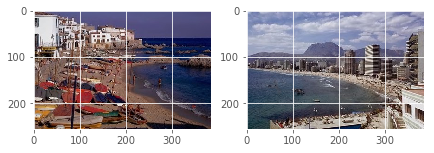

In [49]:
guide_og = plt.imread('116.jpg')[..., :3]
dream_og = plt.imread('118.jpg')[..., :3]

assert(guide_og.ndim == 3 and guide_og.shape[-1] == 3)
assert(dream_og.ndim == 3 and dream_og.shape[-1] == 3)

guide_img = net['preprocess'](guide_og)[np.newaxis]
dream_img = net['preprocess'](dream_og)[np.newaxis]

fig, axs = plt.subplots(1, 2, figsize=(7, 4))
axs[0].imshow(guide_og)
axs[1].imshow(dream_og)



In [79]:
# original code provided by Mital

x = g.get_tensor_by_name(names[0] + ":0")

# Experiment with the weighting
feature_loss_weight = 0.99

with tf.Session(graph=g) as sess, g.device(device):
    feature_loss = tf.Variable(0.0)
    
    # Explore different layers/subsets of layers.  This is just an example.
    # for feature_i in features[2:5]:
    for idx_i, feature_i in enumerate(features[1:5]):

        # Get the activation of the feature
        layer = g.get_tensor_by_name(feature_i)
        print(feature_i)
        
        # Do the same for our guide image
        guide_layer = sess.run(layer, feed_dict={x: guide_img})
            
        
        # Now we need to measure how similar they are!
        # We'll use the dot product, which requires us to first reshape both
        # features to a 2D vector.  But you should experiment with other ways
        # of measuring similarity such as l1 or l2 loss.
        
        # Reshape each layer to 2D vector
        layer = tf.reshape(layer, [-1, 1])
        guide_layer = guide_layer.reshape(-1, 1)
        
        # Now calculate their dot product
        correlation = tf.matmul(guide_layer.T, layer)
        
        # And weight the loss by a factor so we can control its influence
        feature_loss += feature_loss_weight * correlation

net/pool2:0
net/pool3:0
net/pool4:0
net/pool5:0


In [81]:
# original code provided by Mital

n_img, height, width, ch = dream_img.shape

# We'll weight the overall contribution of the total variational loss
# Experiment with this weighting
tv_loss_weight = 2 - feature_loss_weight

with tf.Session(graph=g) as sess, g.device(device):
    
    # Penalize variations in neighboring pixels, enforcing smoothness
    dx = tf.square(x[:, :height - 1, :width - 1, :] - x[:, :height - 1, 1:, :])
    dy = tf.square(x[:, :height - 1, :width - 1, :] - x[:, 1:, :width - 1, :])
    
    # We will calculate their difference raised to a power to push smaller
    # differences closer to 0 and larger differences higher.
    # Experiment w/ the power you raise this to to see how it effects the result
    tv_loss = tv_loss_weight * tf.reduce_mean(tf.pow(dx + dy, 1.2))

In [ ]:
n_iterations = 500
plot_step = 5
step = 0.123
imgs = []

with tf.Session(graph=g) as sess, g.device(device):
    gradient = tf.gradients(-tv_loss + feature_loss, x)

    img_copyd = dream_img.copy()
    img_copyg = guide_img.copy()

    with tf.Session(graph=g) as sess, g.device(device):
        sess.run(tf.global_variables_initializer())
        
        for it_i in range(n_iterations):

            # ALTERNATE FOR IMAGE COPY AS WELL
            if it_i % 2 == 0:
                this_res = sess.run(gradient[0], feed_dict={x: img_copyd})[0]
            
                # Let's normalize it by the maximum activation
                # this_res /= (np.max(np.abs(this_res) + 1e-8))

                # Or alternatively, we can normalize by standard deviation
                this_res /= (np.std(this_res) + 1e-8)
                #this_res /= (np.std(this_res) / (np.mean(img_copy)) + 1e-10)

                img_copyd += this_res/n_iterations * step
            # SWAPPING    
            else:
                this_res = sess.run(gradient[0], feed_dict={x: img_copyg})[0]
                # Let's normalize it by the maximum activation
                # this_res /= (np.max(np.abs(this_res) + 1e-8))

                # Or alternatively, we can normalize by standard deviation
                this_res /= (np.std(this_res) + 1e-8)
                #this_res /= (np.std(this_res) / (np.mean(img_copy)) + 1e-10)

                img_copyg += this_res/n_iterations * step
            
            if (it_i + 1) % plot_step == 0:
                m = net['deprocess']((img_copyd[0]+img_copyg[0])/2)

                plt.figure(figsize=(5, 5))
                plt.grid('off')
                plt.imshow(m)
                plt.show()
                
                imgs.append(m)
                
gif.build_gif(imgs, saveto='final_guided_a.gif') 

In [3]:
ipyd.Image(url='guided.gif', height=300, width=300)

So this is the baseline result. Quite the mess. Let's see what happens when we run the same code with a simple addition of swapping the guide and dream images each iteration, which we can do by adding a tiny bit of code

In [101]:
x = g.get_tensor_by_name(names[0] + ":0")

feature_loss_weight = 1.123

with tf.Session(graph=g) as sess, g.device(device):
    feature_loss = tf.Variable(0.0)
    
    for idx_i, feature_i in enumerate(features[0:5]):

        layer = g.get_tensor_by_name(feature_i)
        print(feature_i)
        
        
        #ALTERNATE GUIDE AND DREAM IMAGES
        if idx_i % 2 == 1:
            guide_layer = sess.run(layer, feed_dict={x: dream_img})
        else:
            guide_layer = sess.run(layer, feed_dict={x: guide_img})
            print(idx_i)
            
        layer = tf.reshape(layer, [-1, 1])
        guide_layer = guide_layer.reshape(-1, 1)
        
        correlation = tf.matmul(guide_layer.T, layer)
        
        feature_loss += feature_loss_weight * correlation

net/pool1:0
0
net/pool2:0
net/pool3:0
2
net/pool4:0
net/pool5:0
4


In [102]:
tv_loss_weight = 2 - feature_loss_weight

with tf.Session(graph=g) as sess, g.device(device):
    dx = tf.square(x[:, :height - 1, :width - 1, :] - x[:, :height - 1, 1:, :])
    dy = tf.square(x[:, :height - 1, :width - 1, :] - x[:, 1:, :width - 1, :])
    
    tv_loss = tv_loss_weight * tf.reduce_mean(tf.pow(dx + dy, 1.2))

In [ ]:
n_iterations = 500
plot_step = 5
step = 0.123
imgs = []

with tf.Session(graph=g) as sess, g.device(device):
    gradient = tf.gradients(-tv_loss + feature_loss, x)

    img_copyd = dream_img.copy()
    img_copyg = guide_img.copy()

    with tf.Session(graph=g) as sess, g.device(device):
        sess.run(tf.global_variables_initializer())
        
        for it_i in range(n_iterations):

            # ALTERNATE FOR IMAGE COPY AS WELL
            if it_i % 2 == 0:
                this_res = sess.run(gradient[0], feed_dict={x: img_copyd})[0]
            
                # Let's normalize it by the maximum activation
                # this_res /= (np.max(np.abs(this_res) + 1e-8))

                # Or alternatively, we can normalize by standard deviation
                this_res /= (np.std(this_res) + 1e-8)
                #this_res /= (np.std(this_res) / (np.mean(img_copy)) + 1e-10)

                img_copyd += this_res/n_iterations * step
            # SWAPPING    
            else:
                this_res = sess.run(gradient[0], feed_dict={x: img_copyg})[0]
                # Let's normalize it by the maximum activation
                # this_res /= (np.max(np.abs(this_res) + 1e-8))

                # Or alternatively, we can normalize by standard deviation
                this_res /= (np.std(this_res) + 1e-8)
                #this_res /= (np.std(this_res) / (np.mean(img_copy)) + 1e-10)

                img_copyg += this_res/n_iterations * step
            
            if (it_i + 1) % plot_step == 0:
                m = net['deprocess']((img_copyd[0]+img_copyg[0])/2)

                plt.figure(figsize=(5, 5))
                plt.grid('off')
                plt.imshow(m)
                plt.show()
                
                imgs.append(m)
                
gif.build_gif(imgs, saveto='final_guided_a.gif') 

In [4]:
ipyd.Image(url='final_guided_a.gif', height=300, width=300)

Interesting, so now here we get what starts off as a mixture, almost like an alpha blend, of both photos. Yet, some different things develop than we would presumably get if we did a photoshop alphablend. Firstly, the mountains in the dream picture are turned into shadow-like impressions leading up to the city in the guide picture. The beaches and waters combine to something like a delta or sandbar, and boats and people are brought together. Some weirdness abounds, like the semi-transparent highrise, and the synthesis becomes more painterly as it continues.

Let's see what happens if we normalize one of the images differently. Perhaps we can factor in the opposite images a second time by using a little sin/cos oscillation and see what happens?

In [5]:
ipyd.Image(url='final_guided_b.gif', height=300, width=300)

Just experimenting a bit with the numbers, but now it kind of has a Rembrandtesque look to it with the darkening of the bottom and right side of the image. The highrise still picks up the colors of the other picture, but no longer is as transparent looking, which is good. Very interesting is that the water appears to have receded - the boats are now sitting on what looks to be sand. However, this time around it seems to have reached a final image very early in the iteration sequence (see the gif). Also, by now it's obvious that we're not hallucinating at all - rather it is just an interesting mixture, perhaps more like the style transfer (or style and content transfer) than the deep dream. Perhaps we need to return a bit to the original design?

In [6]:
ipyd.Image(url='final_guided_c.gif', height=300, width=300)

Ran that a little long - highly oversaturated. Yet, interesting how the white houses remain so relatively intact coloristically compared to the rest of the image. Let's see how some noise works mixed in.

In [8]:
ipyd.Image(url='final_guided_d.gif', height=300, width=300)

In particular, I like the combination of 'final_guided_d.gif'. Has a very acidic, polluted look, if that's your thing. But, how does it perform with other images? Let's try a few similar and different combinations

/Users/jonathansherman/anaconda3/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


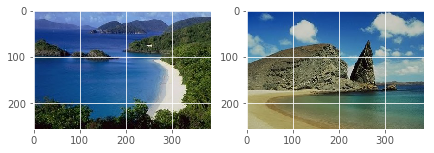

In [6]:
guide_og = plt.imread('133.jpg')[..., :3]
dream_og = plt.imread('136.jpg')[..., :3]

assert(guide_og.ndim == 3 and guide_og.shape[-1] == 3)
assert(dream_og.ndim == 3 and dream_og.shape[-1] == 3)

guide_img = net['preprocess'](guide_og)[np.newaxis]
dream_img = net['preprocess'](dream_og)[np.newaxis]

fig, axs = plt.subplots(1, 2, figsize=(7, 4))
axs[0].imshow(guide_og)
axs[1].imshow(dream_og)

In [10]:
ipyd.Image(url='final_guided_e.gif', height=300, width=300)

Equal weighting of step factor on each component that sum to 1 seems to help the color content stay relatively under control, whilst taking on the smeary dream-like features. 

In [11]:
ipyd.Image(url='final_guided_f.gif', height=300, width=300)

Version with arctan2, slightly different and perhaps smoother and more balanced. Let's try changing some parameters for the next set of images. 

/Users/jonathansherman/anaconda3/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


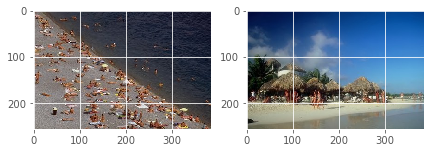

In [5]:
guide_og = plt.imread('164.jpg')[..., :3]
dream_og = plt.imread('162.jpg')[..., :3]

assert(guide_og.ndim == 3 and guide_og.shape[-1] == 3)
assert(dream_og.ndim == 3 and dream_og.shape[-1] == 3)

guide_img = net['preprocess'](guide_og)[np.newaxis]
dream_img = net['preprocess'](dream_og)[np.newaxis]

fig, axs = plt.subplots(1, 2, figsize=(7, 4))
axs[0].imshow(guide_og)
axs[1].imshow(dream_og)

In [13]:
ipyd.Image(url='final_guided_g.gif', height=300, width=300)

The results with arctan2 conjugate between alternating iterations. The image is more believable as "one" image as color information increases, yet becomes less realistic and more painterly. Let's try the technique on the style transfer network.

In [27]:
sess.close()
tf.reset_default_graph()

g = tf.Graph()

with tf.Session(graph=g) as sess, g.device(device):
    
    # Now load the graph_def, which defines operations and their values into `g`
    tf.import_graph_def(net['graph_def'], name='net')

In [28]:
names = [op.name for op in g.get_operations()]
print(names)

['net/images', 'net/mul/y', 'net/mul', 'net/split/split_dim', 'net/split', 'net/sub/y', 'net/sub', 'net/sub_1/y', 'net/sub_1', 'net/sub_2/y', 'net/sub_2', 'net/concat/concat_dim', 'net/concat', 'net/conv1_1/filter', 'net/conv1_1/Conv2D', 'net/conv1_1/biases', 'net/conv1_1/BiasAdd', 'net/conv1_1/conv1_1', 'net/conv1_2/filter', 'net/conv1_2/Conv2D', 'net/conv1_2/biases', 'net/conv1_2/BiasAdd', 'net/conv1_2/conv1_2', 'net/pool1', 'net/conv2_1/filter', 'net/conv2_1/Conv2D', 'net/conv2_1/biases', 'net/conv2_1/BiasAdd', 'net/conv2_1/conv2_1', 'net/conv2_2/filter', 'net/conv2_2/Conv2D', 'net/conv2_2/biases', 'net/conv2_2/BiasAdd', 'net/conv2_2/conv2_2', 'net/pool2', 'net/conv3_1/filter', 'net/conv3_1/Conv2D', 'net/conv3_1/biases', 'net/conv3_1/BiasAdd', 'net/conv3_1/conv3_1', 'net/conv3_2/filter', 'net/conv3_2/Conv2D', 'net/conv3_2/biases', 'net/conv3_2/BiasAdd', 'net/conv3_2/conv3_2', 'net/conv3_3/filter', 'net/conv3_3/Conv2D', 'net/conv3_3/biases', 'net/conv3_3/BiasAdd', 'net/conv3_3/conv3_

255


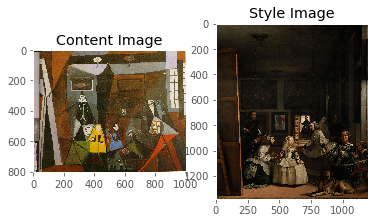

In [29]:
content_og = plt.imread('las_meninas_p.jpg')[..., :3]
style_og = plt.imread('las_meninas_v.jpg')[..., :3]

fig, axs = plt.subplots(1, 2)
axs[0].imshow(content_og)
axs[0].set_title('Content Image')
axs[0].grid('off')
axs[1].imshow(style_og)
axs[1].set_title('Style Image')
axs[1].grid('off')

# We'll save these with a specific name to include in your submission
plt.imsave(arr=content_og, fname='content.png')
plt.imsave(arr=style_og, fname='style.png')
print(style_og.max())

In [30]:
content_img = net['preprocess'](content_og)[np.newaxis]
style_img = net['preprocess'](style_og)[np.newaxis]

/Users/jonathansherman/anaconda3/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [31]:
# Grab the tensor defining the input to the network
x = g.get_tensor_by_name(names[0] + ':0')

# And grab the tensor defining the softmax layer of the network
softmax = g.get_tensor_by_name(names[-2] + ':0')

# Remember from the lecture that we have to set the dropout
# "keep probability" to 1.0.
keep_probability = np.ones([1, 4096])

for img in [content_img, style_img]:
    with tf.Session(graph=g) as sess, g.device('/cpu:0'):
        res = softmax.eval(feed_dict={x: img,
                    'net/dropout_1/random_uniform:0': keep_probability,
                    'net/dropout/random_uniform:0': keep_probability})[0]
        print([(res[idx], net['labels'][idx])
               for idx in res.argsort()[-5:][::-1]])

[(0.99999976, (787, 'n04192698 shield, buckler')), (2.4036294e-07, (496, 'n03026506 Christmas stocking')), (2.8265361e-09, (892, 'n04548280 wall clock')), (1.5672862e-09, (921, 'n07248320 book jacket, dust cover, dust jacket, dust wrapper')), (3.2744815e-10, (861, 'n04447861 toilet seat'))]
[(0.56907588, (887, 'n04532106 vestment')), (0.2185296, (762, 'n04081281 restaurant, eating house, eating place, eatery')), (0.073681787, (424, 'n02791270 barbershop')), (0.046706177, (423, 'n02791124 barber chair')), (0.034475978, (427, 'n02795169 barrel, cask'))]


In [32]:
# Experiment w/ different layers here.  You'll need to change this if you 
# use another network!
content_layer = 'net/conv3_3/conv3_3:0'

# MIX THE IMAGES HERE
content_mix = (content_img+style_img)/2

print(content_mix)

with tf.Session(graph=g) as sess, g.device('/cpu:0'):
    content_features = g.get_tensor_by_name(content_layer).eval(
            session=sess,
            feed_dict={x: content_mix,
                    'net/dropout_1/random_uniform:0': keep_probability,
                    'net/dropout/random_uniform:0': keep_probability})

[[[[ 0.08662465  0.09642857  0.04152661]
   [ 0.09422446  0.10139232  0.04289643]
   [ 0.11649913  0.12018873  0.06036415]
   ..., 
   [ 0.53728282  0.50329995  0.42797536]
   [ 0.65207911  0.61167359  0.55871493]
   [ 0.64574492  0.59956706  0.5255512 ]]

  [[ 0.0920861   0.10189003  0.04698806]
   [ 0.09557823  0.10186605  0.04696409]
   [ 0.09946728  0.10534964  0.05240846]
   ..., 
   [ 0.58524442  0.5200603   0.46668354]
   [ 0.64588428  0.59771878  0.52643156]
   [ 0.65761387  0.61374134  0.54540473]]

  [[ 0.0818378   0.08931328  0.03441132]
   [ 0.09211685  0.09508866  0.04309724]
   [ 0.09786587  0.10374823  0.05080705]
   ..., 
   [ 0.59837914  0.53652257  0.4845311 ]
   [ 0.66118932  0.59977162  0.53436792]
   [ 0.63889414  0.58599794  0.51785815]]

  ..., 
  [[ 0.22179298  0.10891657  0.02842375]
   [ 0.24145579  0.12282601  0.04331911]
   [ 0.23919317  0.11762455  0.0391319 ]
   ..., 
   [ 0.1533993   0.10564332  0.05548638]
   [ 0.15622248  0.12891157  0.07912165]
   [ 0.

In [47]:
# Experiment with different layers and layer subsets.  You'll need to change these
# if you use a different network!
style_layers = ['net/conv1_1/conv1_1:0',
                'net/conv1_2/filter:0',
                'net/conv2_1/conv2_1:0',
                'net/conv2_1/Conv2D:0',
                'net/conv3_1/conv3_1:0',
                'net/conv3_3/BiasAdd:0',
                'net/conv4_1/conv4_1:0',
                'net/conv5_1/conv5_1:0']
style_activations = []

with tf.Session(graph=g) as sess, g.device('/cpu:0'):
    for idx_i, style_i in enumerate(style_layers):
        if idx_i%2 == 0:
            style_activation_i = g.get_tensor_by_name(style_i).eval(
                feed_dict={x: content_img,
                        'net/dropout_1/random_uniform:0': keep_probability,
                        'net/dropout/random_uniform:0': keep_probability})
            style_activations.append(style_activation_i)
        else:
            style_activation_i = g.get_tensor_by_name(style_i).eval(
                feed_dict={x: style_img,
                        'net/dropout_1/random_uniform:0': keep_probability,
                        'net/dropout/random_uniform:0': keep_probability})
            style_activations.append(style_activation_i)
            

In [48]:
style_features = []
for style_activation_i in style_activations:
    s_i = np.reshape(style_activation_i, [-1, style_activation_i.shape[-1]])
    gram_matrix = np.matmul(s_i.T, s_i) / s_i.size
    style_features.append(gram_matrix.astype(np.float32))

In [49]:
tf.reset_default_graph()
g = tf.Graph()

# Get the network again
net = vgg16.get_vgg_model()

# Load up a session which we'll use to import the graph into.
with tf.Session(graph=g) as sess, g.device('/cpu:0'):
    # We can set the `net_input` to our content image
    # or perhaps another image
    # or an image of noise
    # perhaps not surprisingly, seems noise affects form where image-based input is more coloration
    
    #HERE EXPERIMENT WITH INCLUDING NORMALIZATION OF BOTH IMAGES, OR JUST ONE
    #THE EXAMPLES C AND D IN THE GIFS BELOW USE THE FOLLOWING CALCULATION
    net_input = (tf.Variable(content_img / (np.std(content_img) / np.mean(content_img)) + 1e-8) + tf.Variable(style_img / (np.std(style_img) / np.mean(style_img)) + 1e-8))/2
    
    #net_input = tf.Variable(content_img / 255.0)
    #net_input = tf.Variable(content_img / (np.std(content_img) / np.mean(content_img)) + 1e-8)
    #net_input = tf.get_variable(
       #name='input',
       #shape=content_img.shape,
       #dtype=tf.float32,
       #initializer=tf.random_normal_initializer(
           #mean=np.mean(content_img), stddev=np.std(content_img)))
    
    # Now we load the network again, but this time replacing our placeholder
    # with the trainable tf.Variable
    tf.import_graph_def(
        net['graph_def'],
        name='net',
        input_map={'images:0': net_input})

In [50]:
with tf.Session(graph=g) as sess, g.device('/cpu:0'):
    content_loss = tf.nn.l2_loss((g.get_tensor_by_name(content_layer) -
                                 content_features) /
                                 content_features.size)

In [51]:
with tf.Session(graph=g) as sess, g.device('/cpu:0'):
    style_loss = np.float32(0.0)
    for style_layer_i, style_gram_i in zip(style_layers, style_features):
        layer_i = g.get_tensor_by_name(style_layer_i)
        layer_shape = layer_i.get_shape().as_list()
        layer_size = layer_shape[1] * layer_shape[2] * layer_shape[3]
        layer_flat = tf.reshape(layer_i, [-1, layer_shape[3]])
        gram_matrix = tf.matmul(tf.transpose(layer_flat), layer_flat) / layer_size
        style_loss = tf.add(style_loss, tf.nn.l2_loss((gram_matrix - style_gram_i) / np.float32(style_gram_i.size)))

In [52]:
def total_variation_loss(x):
    h, w = x.get_shape().as_list()[1], x.get_shape().as_list()[1]
    dx = tf.square(x[:, :h-1, :w-1, :] - x[:, :h-1, 1:, :])
    dy = tf.square(x[:, :h-1, :w-1, :] - x[:, 1:, :w-1, :])
    return tf.reduce_sum(tf.pow(dx + dy, 1.25))

with tf.Session(graph=g) as sess, g.device('/cpu:0'):
    tv_loss = total_variation_loss(net_input)

In [ ]:
with tf.Session(graph=g) as sess, g.device('/cpu:0'):
    # Experiment w/ the weighting of these!  They produce WILDLY different
    # results.
    loss = 5.0 * content_loss + 1.0 * style_loss + 0.001 * tv_loss
    optimizer = tf.train.AdamOptimizer(0.05).minimize(loss)

In [ ]:
imgs = []
n_iterations = 100

with tf.Session(graph=g) as sess, g.device('/cpu:0'):
    sess.run(tf.global_variables_initializer())

    # map input to noise
    og_img = net_input.eval()
    
    for it_i in range(n_iterations):
        _, this_loss, synth = sess.run([optimizer, loss, net_input], feed_dict={
                    'net/dropout_1/random_uniform:0': keep_probability,
                    'net/dropout/random_uniform:0': keep_probability})
        print("%d: %f, (%f - %f)" %
            (it_i, this_loss, np.min(synth), np.max(synth)))
        if it_i % 5 == 0:
            m = vgg16.deprocess(synth[0])
            imgs.append(m)
            plt.imshow(m)
            plt.show()
    gif.build_gif(imgs, saveto='stylenet_e.gif')

While the program crashed out too many times to want to do it again in Jupyter notebook, these style/content transfer examples are very interesting. The following constructs were used for each example

stylenet_a = style_img precedes content_img in swap iteration & only content_img is input
stylenet_b = content_img precedes style_img in swap iteration & only content_img is input
stylenet_c = style_img precedes content_img in swap iteration & norm of content_img and style_img is input
stylenet_d = content_img precedes style_img in swap iteration & norm of content_img and style_img is input

The stylenet.gif from the course, with no swapping/conflation of style and content images. The paintings, I should have mentioned, are of Velazquez and one of Picasso's versions of Velazquez's masterpiece, **Las Meninas**. I chose to reverse the process with the network, and have Picasso be the content and Velazquez's original be the style image. With or without the swapping/conflation of the style and content images, this network is quite fascinating.

Below is the style transfer with no alternation.

In [14]:
ipyd.Image(url='stylenet.gif', height=300, width=300)

stylenet_a. Note we can start to see more figure from the style painting (Velazquez's original) appear.

In [15]:
ipyd.Image(url='stylenet_a.gif', height=300, width=300)

style_net_b. 

In [17]:
ipyd.Image(url='stylenet_b.gif', height=300, width=300)

style_net_c. Note the man in the door in the Velazquez original has reappeared here in the lower center right region.

In [19]:
ipyd.Image(url='stylenet_c.gif', height=300, width=300)

style_net_d. I think this is my favorite - it most reclaims Velazquez's original with Picasso's form. Interesting that marbled texture shows up on the columns.

In [21]:
ipyd.Image(url='stylenet_d.gif', height=300, width=300)

style_net_d. 500 iterations.

In [42]:
ipyd.Image(url='stylenet_d500.gif', height=300, width=300)